In [6]:
# load required packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load required functionality from keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5368198558317355868
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8369810307203559952
physical_device_desc: "device: XLA_CPU device"
]


**Convolutional Neural Network (CNN)**
Now let's try out first deep neural network: a Convolutional Neural Network (CNN).

The CNN is made up of a few core layer types, which get stacked on top of each other:
- convolutional layers (2D)
- max pooling layers (2D)
- fully connected (aka densely connected) layers (same type as in the MLP model)


First, we need to perform pre-processing on the MNIST data, but with a slight tweak from the previous examples:

(60000, 28, 28)
(10000, 28, 28)
(60000, 784)


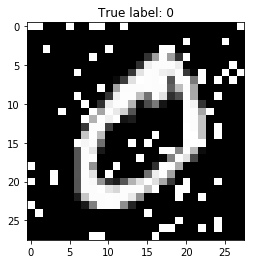

In [7]:
# load the data again (to be safe)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

"""
    Adding noise to image
"""
import random 

print(X_train.shape)
print(X_test.shape)

# 10%, 20%, 40%
img_size = 28*28

X_train_10 = np.zeros((60000, 28*28))
X_test_10 = np.zeros((10000, 28*28))
X_train_20 = np.zeros((60000, 28*28))
X_test_20 = np.zeros((10000, 28*28))
X_train_40 = np.zeros((60000, 28*28))
X_test_40 = np.zeros((10000, 28*28))

for i in range(len(X_train)): 
    ran_seq = random.sample([n for n in range(img_size)], np.int(img_size* 0.1)) 
    ran_seq2 = random.sample([n for n in range(img_size)], np.int(img_size* 0.2)) 
    ran_seq3 = random.sample([n for n in range(img_size)], np.int(img_size* 0.4)) 
    X_train_10[i] = X_train[i].reshape(-1, img_size) 
    X_train_20[i] = np.copy(X_train_10[i])
    X_train_40[i] = np.copy(X_train_10[i])
    X_train_10[i, ran_seq] = 255
    X_train_20[i, ran_seq2] = 255
    X_train_40[i, ran_seq3] = 255

for i in range(len(X_test)):
    ran_seq = random.sample([n for n in range(img_size)], np.int(img_size* 0.1)) 
    ran_seq2 = random.sample([n for n in range(img_size)], np.int(img_size* 0.2)) 
    ran_seq3 = random.sample([n for n in range(img_size)], np.int(img_size* 0.4)) 
    X_test_10[i] = X_test[i].reshape(-1, img_size) 
    X_test_20[i] = np.copy(X_test_10[i])
    X_test_40[i] = np.copy(X_test_10[i])
    X_test_10[i, ran_seq] = 255
    X_test_20[i, ran_seq2] = 255
    X_test_40[i, ran_seq3] = 255
    
print(X_train_10.shape)
#print(x[1])

img = X_train_10[1].reshape(28, 28)
label = y_train[1]

# show the image and its label
plt.imshow(img, cmap='gray')
plt.title("True label: %d" % label)
plt.show()



(60000, 28, 28, 1)


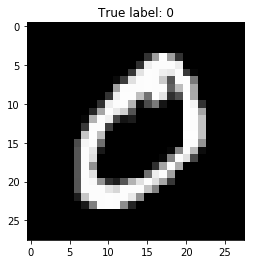

In [8]:
# reshape the data based on what backend is in use (TensorFlow or Thean)
if keras_backend.image_data_format() == 'channels_first': #Thean
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_test = X_test.reshape(-1, 1, 28, 28)
else: # TensorFlow
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)
    X_train_10 = X_train_10.reshape(-1, 28, 28, 1)
    X_train_20 = X_train_20.reshape(-1, 28, 28, 1)
    X_train_40 = X_train_40.reshape(-1, 28, 28, 1)
    X_test_10 = X_test_10.reshape(-1, 28, 28, 1)
    X_test_20 = X_test_20.reshape(-1, 28, 28, 1)
    X_test_40 = X_test_40.reshape(-1, 28, 28, 1)

print(X_train.shape)

img = X_train[1, :, :, 0]
label = y_train[1]

# show the image and its label
plt.imshow(img, cmap='gray')
plt.title("True label: %d" % label)
plt.show()


# convert data type and normalize the values (8-bit = 256 = 0...255)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train_10 = X_train_10.astype('float32') / 255
X_train_20 = X_train_20.astype('float32') / 255
X_train_40 = X_train_40.astype('float32') / 255
X_test_10 = X_test_10.astype('float32') / 255
X_test_20 = X_test_20.astype('float32') / 255
X_test_40 = X_test_40.astype('float32') / 255

# convert the class labels to 10-dimensional class arrays:
# - before: y_train = (n_samples, )
# - after: Y_train = (n_samples, 10)
#
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [13]:
# create the CNN model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1),
                 padding="same"
                ))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(1, (3, 3), activation='relu', padding="same"))

print(model.summary())

model.compile(loss='mean_absolute_error',
              optimizer=Adam(),
              metrics=['accuracy'])

model.fit(X_train_40, X_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test_40, X_test))

"""
print("== 10% ==")
model.fit(X_train_10, Y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test_10, Y_test))

score = model.evaluate(X_test_10, Y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


print("== 20% ==")
model.fit(X_train_20, Y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test_20, Y_test))

score = model.evaluate(X_test_20, Y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


print("== 40% ==")
model.fit(X_train_40, Y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test_40, Y_test))

score = model.evaluate(X_test_40, Y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
"""

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_11 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_13 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_14 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 64)        36928     
__________

'\nprint("== 10% ==")\nmodel.fit(X_train_10, Y_train,\n          batch_size=128,\n          epochs=2,\n          verbose=1,\n          validation_data=(X_test_10, Y_test))\n\nscore = model.evaluate(X_test_10, Y_test, verbose=0)\n\nprint(\'Test loss:\', score[0])\nprint(\'Test accuracy:\', score[1])\n\n\nprint("== 20% ==")\nmodel.fit(X_train_20, Y_train,\n          batch_size=128,\n          epochs=2,\n          verbose=1,\n          validation_data=(X_test_20, Y_test))\n\nscore = model.evaluate(X_test_20, Y_test, verbose=0)\n\nprint(\'Test loss:\', score[0])\nprint(\'Test accuracy:\', score[1])\n\n\nprint("== 40% ==")\nmodel.fit(X_train_40, Y_train,\n          batch_size=128,\n          epochs=2,\n          verbose=1,\n          validation_data=(X_test_40, Y_test))\n\nscore = model.evaluate(X_test_40, Y_test, verbose=0)\n\nprint(\'Test loss:\', score[0])\nprint(\'Test accuracy:\', score[1])\n'

== Noise remove accuracy ==
Train loss: 0.016546125790973504
Train accuracy: 0.8143690053939819
Test loss: 0.01638315934240818
Test accuracy: 0.8134149232864379


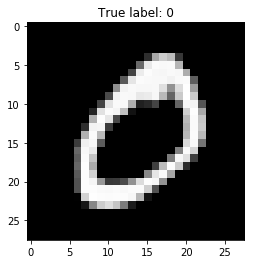

In [14]:
print("== Noise remove accuracy ==")
score = model.evaluate(X_train_40, X_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
score = model.evaluate(X_test_40, X_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

X_train_10_removeNoise = model.predict(X_train_10)
X_train_20_removeNoise = model.predict(X_train_20)
X_train_40_removeNoise = model.predict(X_train_40)
X_test_10_removeNoise = model.predict(X_test_10)
X_test_20_removeNoise = model.predict(X_test_20)
X_test_40_removeNoise = model.predict(X_test_40)


img = X_train_40_removeNoise[1, :, :, 0]
label = y_train[1]

# show the image and its label
plt.imshow(img, cmap='gray')
plt.title("True label: %d" % label)
plt.show()

In [15]:
# create the CNN model
model2 = Sequential()

model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)
                ))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

print("== 10% with remove noise ==")
model2.fit(X_train_10_removeNoise, Y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test_10_removeNoise, Y_test))

score = model2.evaluate(X_test_10_removeNoise, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


print("== 20% with remove noise ==")
model2.fit(X_train_20_removeNoise, Y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test_20_removeNoise, Y_test))

score = model2.evaluate(X_test_20_removeNoise, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


print("== 40% with remove noise ==")
model2.fit(X_train_40_removeNoise, Y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test_40_removeNoise, Y_test))

score = model2.evaluate(X_test_40_removeNoise, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

== 10% with remove noise ==
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 46s 769us/step - loss: 0.2735 - acc: 0.9151 - val_loss: 0.0699 - val_acc: 0.9781
Epoch 2/2
60000/60000 [==============================] - 47s 778us/step - loss: 0.0922 - acc: 0.9733 - val_loss: 0.0437 - val_acc: 0.9860
Test loss: 0.04371540787173435
Test accuracy: 0.986
== 20% with remove noise ==
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 45s 749us/step - loss: 0.0700 - acc: 0.9794 - val_loss: 0.0408 - val_acc: 0.9860
Epoch 2/2
60000/60000 [==============================] - 45s 743us/step - loss: 0.0586 - acc: 0.9828 - val_loss: 0.0371 - val_acc: 0.9881
Test loss: 0.037110773968260034
Test accuracy: 0.9881
== 40% with remove noise ==
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 45s 756us/step - loss: 0.0629 - acc: 0.9810 - val_l